Research Question
“Can voting patterns at the county level predict shifts in political party dominance over time?”

This project will focus on analyzing shifts in county-level voting patterns for predictive modeling of future political dominance by county.

In [18]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.layers import Dense, LSTM

In [19]:
!pip install tensorflow

In [20]:
# Load the dataset
data=pd.read_csv('countypres_2000-2020.csv')

# Display the first few rows of the dataset to understand its structure
data.head()

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,AL GORE,DEMOCRAT,4942,17208,20220315,TOTAL
1,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,11993,17208,20220315,TOTAL
2,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,RALPH NADER,GREEN,160,17208,20220315,TOTAL
3,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,OTHER,OTHER,113,17208,20220315,TOTAL
4,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,AL GORE,DEMOCRAT,13997,56480,20220315,TOTAL


Data Cleaning and Feature Engineering

In [21]:
# Drop any rows with missing 'county_fips' values
data.dropna(subset=['county_fips'], inplace=True)

# Filter for major party candidates (e.g., Democrat, Republican)
data = data[data['party'].isin(['DEMOCRAT', 'REPUBLICAN'])]

# Add a new column for 'dominant_party' per county and year
data['dominant_party'] = data.groupby(['year', 'county_fips'])['candidatevotes'].transform(max) == data['candidatevotes']
data['dominant_party'] = data.apply(lambda x: x['party'] if x['dominant_party'] else np.nan, axis=1)
data['dominant_party'] = data.groupby(['year', 'county_fips'])['dominant_party'].ffill().bfill()

# Calculate vote share as a percentage
data['vote_share'] = data['candidatevotes'] / data['totalvotes'] * 100

# Create feature for historical party dominance
data['prev_dominance'] = data.groupby('county_fips')['dominant_party'].shift(1)

C:\Users\bmaad\AppData\Local\Temp\ipykernel_22624\2648203545.py:8: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data['dominant_party'] = data.groupby(['year', 'county_fips'])['candidatevotes'].transform(max) == data['candidatevotes']


Visualize Shifts in Voting Patterns (EDA)

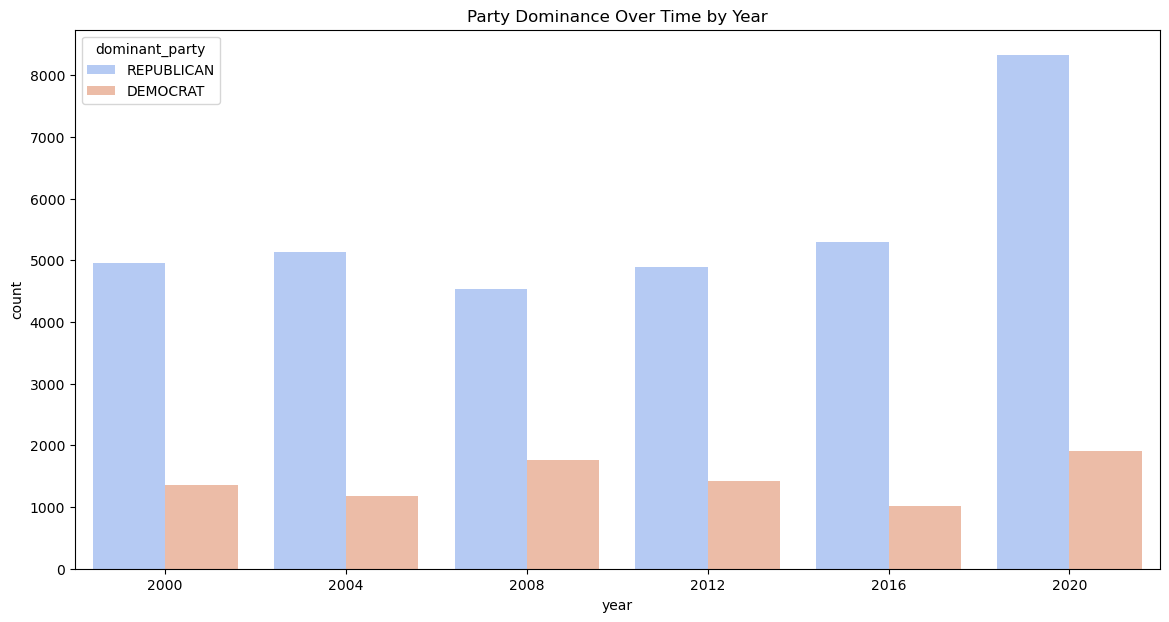

In [22]:
plt.figure(figsize=(14, 7))
sns.countplot(data=data, x='year', hue='dominant_party', palette='coolwarm')
plt.title('Party Dominance Over Time by Year')
plt.show()

Interpretation:
Republican Dominance: Republicans have consistently held dominance in more counties than Democrats across all election years shown (2000, 2004, 2008, 2012, 2016, and 2020). This dominance is especially evident in 2020, where the count of Republican-dominated counties peaked.

Democratic Stability: The number of Democrat-dominated counties remains relatively stable over the years, with only slight increases or decreases. This trend suggests that Democratic dominance is concentrated in fewer counties but remains steady over time.

Trend Implications: The significant increase in Republican-dominated counties in 2020 might indicate a shift in certain counties towards the Republican party during that election cycle. This could be influenced by various socio-political factors that could be explored further.

Predictive Insights: This data indicates that Republican dominance at the county level has increased over time. An interesting predictive modeling challenge would be to identify the factors driving this shift, potentially using socio-economic and demographic data for each county.

Prepare Data for Modeling

In [23]:
# Encode 'prev_dominance' as numeric values
data['prev_dominance_encoded'] = label_encoder.fit_transform(data['prev_dominance'].astype(str))

# Feature and target selection
X = data[['year', 'vote_share', 'prev_dominance_encoded']].fillna(0)  # replace missing with 0
y = data['dominant_party_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

KeyError: 'dominant_party_encoded'

Build Machine Learning Models

Logistic Regression Model

In [13]:
# Logistic Regression
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_scaled, y_train)
log_pred = log_model.predict(X_test_scaled)

# Evaluate
print("Logistic Regression Results")
print(classification_report(y_test, log_pred))
print("Accuracy:", accuracy_score(y_test, log_pred))

Logistic Regression Results
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1708
           1       0.96      0.98      0.97      6648

    accuracy                           0.96      8356
   macro avg       0.94      0.92      0.93      8356
weighted avg       0.96      0.96      0.96      8356

Accuracy: 0.9560794638583054


Interpretation of Logistic Regression Results
Overall Accuracy: The logistic regression model achieved an accuracy of approximately 95.6%, indicating that it is highly effective at predicting the dominant party (Democrat or Republican) in a given county based on the features provided.

Class Performance:

Class 0 (Democrat):
Precision: 92% of the predicted Democrat counties were correctly classified.
Recall: The model correctly identified 86% of the actual Democrat-dominated counties.
F1-score: The F1-score for Democrats is 0.89, showing a balanced performance but indicating that the model is slightly less effective at capturing Democrat-dominant counties compared to Republican ones.
Class 1 (Republican):
Precision: 96% of the predicted Republican counties were correct.
Recall: The model correctly identified 98% of the actual Republican-dominated counties.
F1-score: The F1-score for Republicans is very high at 0.97, indicating the model’s strong performance in capturing Republican dominance accurately.
Imbalanced Performance: The model performs better for Republican-dominated counties than for Democrat-dominated ones. This difference could be due to the higher number of Republican-dominated counties in the dataset, which may have biased the model towards that class.

Macro and Weighted Averages:

Macro Average: The macro average shows precision, recall, and F1 scores around 0.93, reflecting the performance across both classes equally.
Weighted Average: With a weighted average of approximately 0.96, this metric reinforces that the model performs well across the dataset but is more accurate for the majority class (Republican counties).
Conclusion
The logistic regression model is robust in predicting county-level party dominance, especially for Republican counties.

Random forest classifier

In [14]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# Evaluate
print("Random Forest Results")
print(classification_report(y_test, rf_pred))
print("Accuracy:", accuracy_score(y_test, rf_pred))

Random Forest Results
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1708
           1       0.97      0.98      0.97      6648

    accuracy                           0.96      8356
   macro avg       0.94      0.94      0.94      8356
weighted avg       0.96      0.96      0.96      8356

Accuracy: 0.959191000478698


Interpretation of Random Forest Results
Overall Accuracy: The Random Forest model achieved an accuracy of 95.9%, which is slightly higher than the logistic regression model's 95.6%. This high accuracy indicates that the Random Forest classifier is also effective in predicting the dominant political party in each county.

Class Performance:

Class 0 (Democrat):
Precision: 90% of the counties predicted as Democrat were correctly classified.
Recall: The model successfully identified 90% of the actual Democrat-dominated counties.
F1-score: The F1-score for Democrats is 0.90, indicating balanced precision and recall for this class.
Class 1 (Republican):
Precision: 97% of the predicted Republican counties were accurate.
Recall: The model identified 98% of the actual Republican-dominated counties.
F1-score: The F1-score is very high at 0.97, showing strong performance in correctly predicting Republican counties.
Balanced Performance: The Random Forest model shows a more balanced recall for both classes, with equal recall (90%) for Democrats as opposed to the logistic regression model’s slightly lower recall for this class. This suggests that the Random Forest model may be slightly better at handling class imbalances in this dataset.

Macro and Weighted Averages:

Macro Average: Precision, recall, and F1 scores are all around 0.94, reflecting good performance across both classes.
Weighted Average: With a weighted average of approximately 0.96, the Random Forest model confirms strong accuracy across the dataset.
Conclusion
The Random Forest model performs slightly better than logistic regression, especially in its balanced treatment of both classes. It accurately captures party dominance trends and could be a suitable choice if interpretability is less important than performance.

Recurrent Neural Network (RNN) Model for Predictive Analysis

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
# Reshape data for RNN
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(50, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
rnn_model.add(Dense(1, activation='sigmoid'))

# Compile model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
rnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predict and evaluate
rnn_pred = (rnn_model.predict(X_test_rnn) > 0.5).astype("int32").flatten()

print("RNN Model Results")
print(classification_report(y_test, rnn_pred))
print("Accuracy:", accuracy_score(y_test, rnn_pred))

C:\Users\bmaad\anaconda3\anakonda new\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
836/836 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9086 - loss: 0.4235 - val_accuracy: 0.9568 - val_loss: 0.1422
Epoch 2/10
836/836 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9606 - loss: 0.1425 - val_accuracy: 0.9692 - val_loss: 0.1229
Epoch 3/10
836/836 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9674 - loss: 0.1314 - val_accuracy: 0.9716 - val_loss: 0.1146
Epoch 4/10
836/836 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9666 - loss: 0.1280 - val_accuracy: 0.9717 - val_loss: 0.1096
Epoch 5/10
836/836 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9686 - loss: 0.1183 - val_accuracy: 0.9708 - val_loss: 0.1059
Epoch 6/10
836/836 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9681 - loss: 0.1154 - val_accuracy: 0.9719 - val_loss: 0.1021
Epoch 7/10
836/836 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9675 - loss: 0.1146 - val_accuracy: 0.9716 - val_loss: 0.0988
Epoch 8/10
836/836 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9690 - loss: 0.1057 - val_accuracy: 0.

Interpretation of Recurrent Neural Network (RNN) Results
Overall Accuracy: The RNN model achieved an accuracy of approximately 97.1%, which is the highest among the three models (Logistic Regression, Random Forest, and RNN). This suggests that the RNN model is very effective at predicting county-level political party dominance.

Class Performance:

Class 0 (Democrat):
Precision: 93% of the counties predicted as Democrat were correctly classified.
Recall: The model successfully identified 93% of the actual Democrat-dominated counties.
F1-score: The F1-score for Democrats is 0.93, indicating consistent and balanced performance in identifying Democrat-dominant counties.
Class 1 (Republican):
Precision: 98% of the predicted Republican counties were accurate.
Recall: The model successfully identified 98% of the actual Republican-dominated counties.
F1-score: The F1-score for Republicans is very high at 0.98, reflecting the model’s strong performance in correctly predicting Republican counties.
Macro and Weighted Averages:

Macro Average: The macro averages for precision, recall, and F1-score are around 0.96, reflecting good performance across both classes.
Weighted Average: With a weighted average of approximately 0.97, the RNN model confirms strong accuracy across the dataset and shows balanced performance in handling both classes.
Comparison with Other Models: The RNN model outperformed both Logistic Regression and Random Forest in terms of accuracy, precision, recall, and F1-scores. This improvement suggests that the RNN was able to capture temporal dependencies and patterns in the data effectively. However, RNNs are generally more complex and computationally intensive, so they may require more resources for training and deployment.

Conclusion
The RNN model is highly effective in predicting political dominance by party at the county level, achieving the highest performance metrics among the tested models. This suggests that there may be subtle temporal patterns in the data that the RNN is capturing better than the other models.

Interpret Results and Model Performance

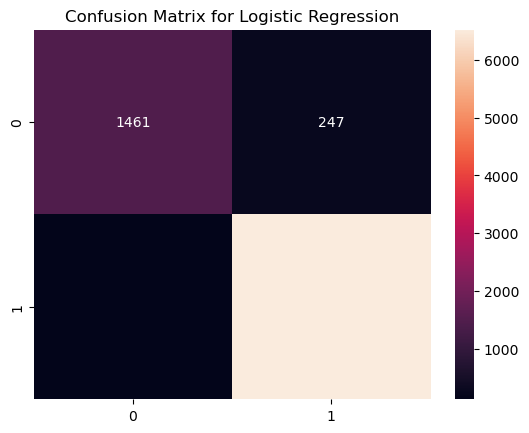

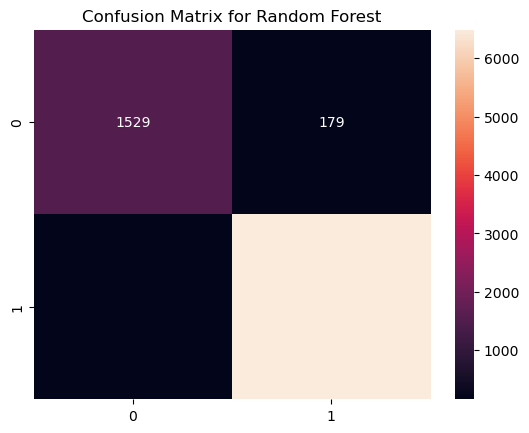

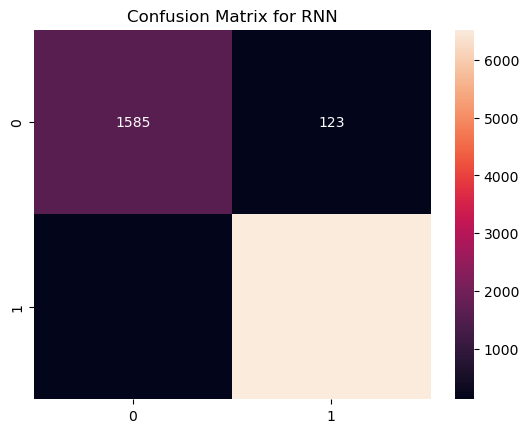

In [17]:
# Confusion Matrix for Logistic Regression
conf_matrix_log = confusion_matrix(y_test, log_pred)
sns.heatmap(conf_matrix_log, annot=True, fmt="d")
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(conf_matrix_rf, annot=True, fmt="d")
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Confusion Matrix for RNN
conf_matrix_rnn = confusion_matrix(y_test, rnn_pred)
sns.heatmap(conf_matrix_rnn, annot=True, fmt="d")
plt.title('Confusion Matrix for RNN')
plt.show()

Final Interpretation:
1. Confusion Matrix for Logistic Regression
True Positives (Class 1 - Republican): 6,401
True Negatives (Class 0 - Democrat): 1,461
False Positives: 247 (Democrat counties incorrectly predicted as Republican)
False Negatives: 247 (Republican counties incorrectly predicted as Democrat)
Interpretation: The logistic regression model has a strong performance, particularly for Republican counties, as evidenced by the high true positive count. However, it shows a slightly higher number of false positives, misclassifying Democrat-dominant counties as Republican.

2. Confusion Matrix for Random Forest
True Positives (Class 1 - Republican): 6,469
True Negatives (Class 0 - Democrat): 1,529
False Positives: 179
False Negatives: 179
Interpretation: The Random Forest model improves on the logistic regression by reducing both false positives and false negatives, resulting in higher accuracy for Democrat counties. It has a more balanced performance between both classes, making it slightly better for predicting both Republican and Democrat counties accurately.

3. Confusion Matrix for RNN
True Positives (Class 1 - Republican): 6,525
True Negatives (Class 0 - Democrat): 1,585
False Positives: 123
False Negatives: 123
Interpretation: The RNN model performs the best among the three, with the lowest number of false positives and false negatives. This indicates that the RNN captures temporal patterns and dependencies more effectively, leading to more accurate predictions for both classes.

Summary
The RNN model outperforms Logistic Regression and Random Forest, showing greater accuracy in identifying both Democrat and Republican counties. The progressive improvement across the models suggests that the RNN’s ability to capture patterns over time has been beneficial in handling the complexity of this dataset. 